In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
#可视化
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
data_path = "D:\\学习\\大三下\\数据挖掘实训\\华为杯\\"
data_path_save = "D:\\学习\\大三下\\数据挖掘实训\\华为杯\\process_csv\\"
#读取数据
age_train = pd.read_csv(data_path + "age_train.csv", names=['uid','age_group'])
age_test = pd.read_csv(data_path + "age_test.csv", names=['uid'])

# user_basic_info:用户标识、性别、常住地、手机型号、手机ram容量、ram剩余容量、rom容量、rom剩余容量占比、手机颜色、字体大小、上网类型、移动运营商、手机系统版本
user_basic_info = pd.read_csv(data_path + "user_basic_info.csv", names=['uid','gender','city','prodName','ramCapacity','ramLeftRation','romCapacity','romLeftRation','color','fontSize','ct','carrier','os'])

#user_behavior_info:手机表示、开机次数、手机ABCDEFG特性使用次数
user_behavior_info = pd.read_csv(data_path + "user_behavior_info.csv", names=['uid','bootTimes','AFuncTimes','BFuncTimes','CFuncTimes','DFuncTimes','EFuncTimes','FFuncTimes','FFuncSum'])

#user_app_actived：用户标识、app标识
user_app_actived = pd.read_csv(data_path + "user_app_actived.csv", names=['uid','appId'])

#app_info:app标识、app所属类型
app_info = pd.read_csv(data_path + "app_info.csv", names=['appId', 'category'])

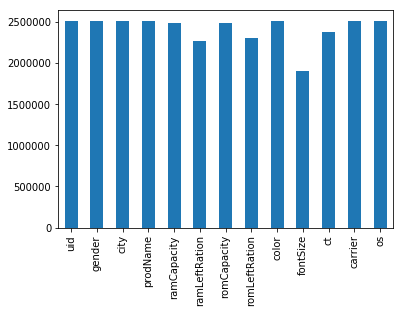

In [5]:
user_basic_info.count().plot(kind='bar')

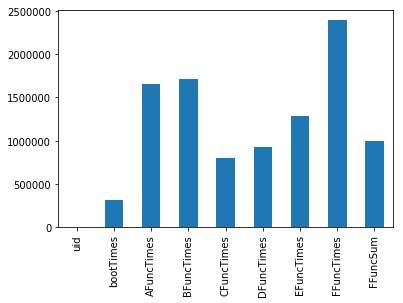

In [6]:
user_behavior_info[user_behavior_info==0].count().plot(kind='bar')

In [7]:
#处理数据缺失
user_basic_info = user_basic_info.fillna({'ramCapacity':4.856,'ramLeftRation':0.34,'romCapacity':82.2,'romLeftRation':0.434,'fontSize':1.1})
user_basic_info.to_csv(data_path + "user_basic_info_clear.csv",index=0)
user_behavior_info['bootTimes'] = user_behavior_info['bootTimes'].apply(lambda x: x if x!= 0 else 20.4)#平均值
user_behavior_info['AFuncTimes'] = user_behavior_info['AFuncTimes'].apply(lambda x: x if x!= 0 else 23)#75%
user_behavior_info['BFuncTimes'] = user_behavior_info['BFuncTimes'].apply(lambda x: x if x!= 0 else -0.07)#75%
user_behavior_info['CFuncTimes'] = user_behavior_info['CFuncTimes'].apply(lambda x: x if x!= 0 else 1.6007)#平均值
user_behavior_info['DFuncTimes'] = user_behavior_info['DFuncTimes'].apply(lambda x: x if x!= 0 else 3.124)#平均值
user_behavior_info['EFuncTimes'] = user_behavior_info['EFuncTimes'].apply(lambda x: x if x!= 0 else 2.43)#75%
user_behavior_info['FFuncSum'] = user_behavior_info['FFuncSum'].apply(lambda x: x if x!= 0 else 11945.9)#平均值
#删除缺失过多的数据列
del user_behavior_info['FFuncTimes']

In [8]:
#第一次处理大文件user_app_usage.csv，从中获得部分基本特征
def f(x):
    s = x.value_counts()
    return np.nan if len(s) == 0 else s.index[0]

def processUserAppUsage1():
    resTable = pd.DataFrame()    #二维的表格型数据结构，可理解为Series的容器
    #user_app_usage:用户标识、app标识、使用时长、打开次数、使用日期
    reader = pd.read_csv(data_path + "user_app_usage.csv", names=['uid','appId','duration','times','use_date'], iterator=True)
    last_df = pd.DataFrame()
    
    app_info = pd.read_csv(data_path + "app_info.csv", names=['appId','category'])
    cats = list(set(app_info['category']))    #set() 函数创建一个无序不重复元素集
                                              #list() 函数创建一个列表
    category2id = dict(zip(sorted(cats), range(0,len(cats))))    #zip() 函数用于将可迭代的对象作为参数，
                                                                 #将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的列表。
    id2category = dict(zip(range(0,len(cats)), sorted(cats)))
    #apply(func [, args [, kwargs ]]) 函数用于当函数参数已经存在于一个元组或字典中时，间接地调用函数。
    #lambda创建匿名函数
    #将app_info.csv中的category字段转换成对应的数字索引
    app_info['category'] = app_info['category'].apply(lambda x: category2id[x])
    i = 1
    
    while True:
        try:
            print("index: {}".format(i))
            i+=1
            df = reader.get_chunk(1000000)   #分块读取大文件对象，get_chunk(1000000)每次读取1000000条数据
            df = pd.concat([last_df, df])    #数据合并
            idx = df.shape[0]-1              #df.shape返回df的维度
            last_user = df.iat[idx,0]        #指定行和列，快速定位元素，找到最后一个用户id
            while(df.iat[idx,0]==last_user):
                idx-=1
            last_df = df[idx+1:]             #最后一个用户的首行记录
            df = df[:idx+1]

            now_df = pd.DataFrame()
            now_df['uid'] = df['uid'].unique()   
            # merge()数据合并
            now_df = now_df.merge(df.groupby('uid')['appId'].count().to_frame(), how='left', on='uid')
            now_df = now_df.merge(df.groupby('uid')['appId','use_date'].agg(['nunique']), how='left', on='uid')
            now_df = now_df.merge(df.groupby('uid')['duration','times'].agg(['mean','max','std']), how='left', on='uid')
            
            now_df.columns = ['uid','usage_cnt','usage_appid_cnt','usage_date_cnt','duration_mean','duration_max','duration_std','times_mean','times_max','times_std']
            now_df['duration_oneday'] = now_df.apply(lambda x:x['duration_mean'] * x['usage_cnt'],axis = 1)
            
            df = df.merge(app_info, how='left', on='appId')
            now_df = now_df.merge(df.groupby('uid')['category'].nunique().to_frame(), how='left', on='uid')
            now_df['usage_most_used_category'] = df.groupby(['uid'])['category'].transform(f)
            resTable = pd.concat([resTable, now_df])
        except StopIteration:
            break
    
    #appuseProcessed:用户id,使用记录总数，不同的app个数，使用天数，使用时长平均数、最大值、平方差，使用次数平均数、最大值、平方差，app类型总数，最常使用的app类型
    resTable.to_csv(data_path_save + "appuseProcessed1.csv",index=0)
    print("Iterator is stopped")

In [ ]:
processUserAppUsage1()

In [10]:
#读取大文件处理得到的数据appuseProcessed1
appusedTable1 = pd.read_csv(data_path_save + "appuseProcessed1.csv")

In [11]:
#处理user_app_actived.csv，获得每个用户激活40个类别app的数目
def getUserCategoryNum():
    cats = list(set(app_info['category']))    #创建一个无序不重复元素集并转换成列表
    category2id = dict(zip(sorted(cats), range(0,len(cats))))
    id2category = dict(zip(range(0,len(cats)), sorted(cats)))
    #将app_info.csv中的category字段转换成对应的数字索引
    app_info['category'] = app_info['category'].apply(lambda x: category2id[x])

    app_info_dict = app_info.groupby('appId')['category'].apply(list)  #将app_info同id合并后，转换成字典
    app_categoryNum_array = np.zeros((user_basic_info.shape[0],40))    #建立二维数组，存储每个用户激活的每类型app数量
    #处理user_app_actived，获得每个用户激活每类app的数量
    k = 0
    for x in user_app_actived['appId']:    #读取用户激活app文件的每条记录
        for y in x.split('#'):             #分词，获得每个appId
            if y in app_info_dict:         #判断appId在字典中是否存在
                category_list = app_info_dict[y]      #通过字典获得该appId对应的类型列表
                for j in range(len(category_list)):
                    app_categoryNum_array[k,category_list[j]] += 1
        k = k + 1
        if(k % 10000 == 0):
            print(k)
    user_app_categoryNum = pd.DataFrame(user_app_categoryNum)   #将数组转换成DataFrame
    user_app_categoryNum = pd.concat([user_app_actived['uid'],user_app_categoryNum],axis=1)   #加入uid列
    user_app_categoryNum.to_csv(data_path_save + "user_app_categoryNum.csv",index=0)

In [ ]:
getUserCategoryNum()

In [12]:
#读取每个用户激活的40个类别app数目
user_app_categoryNum = pd.read_csv(data_path_save + "user_app_categoryNum.csv")

In [13]:
#第二次处理大文件user_app_usage.csv，从中获得每个用户对于40个类别app的使用总时长和总次数
def processUserAppUsage2():
    resTable = pd.DataFrame()    #二维的表格型数据结构，可理解为Series的容器

    #user_app_usage:用户标识、app标识、使用时长、打开次数、使用日期
    reader = pd.read_csv(data_path + "user_app_usage.csv", names=['uid','appId','duration','times','use_date'], iterator=True)

    last_df = pd.DataFrame()

    i = 1

    while True:
        try:
            print("index: {}".format(i))
            i+=1
            df = reader.get_chunk(1000000)   #分块读取大文件对象，get_chunk(1000000)每次读取1000000条记录
            df = pd.concat([last_df, df])    #数据合并
            idx = df.shape[0]-1              #df.shape返回df的维度
            last_user = df.iat[idx,0]        #指定行和列，快速定位元素，找到最后一个用户id
            while(df.iat[idx,0]==last_user):
                idx-=1
            last_df = df[idx+1:]             #最后一个用户的首行记录
            df = df[:idx+1]

            df_modify = df.groupby(by = ['uid','appId'])['duration','times'].agg(['sum']).reset_index()    #将同一用户使用同一app的时长和次数相加
            df_modify.columns = ['uid','appId','duration_sum','times_sum']
            row_len = df_modify.shape[0]
            user_num = df_modify['uid'].unique().shape[0]

            app_category_usage_array = np.zeros((user_num,81))    #建立二维数组，存储每个用户对每个类别app的使用时长和次数

            df_modify['appId'] = df_modify['appId'].apply(lambda x: app_info_dict[x] if x in app_info_dict else [40])
            df_array = df_modify.values

            app_category_usage_dataFrame = pd.DataFrame()    
            userid = df_modify['uid'][0]
            m = 0
            for k in range(0,row_len):
                if(userid != df_array[k,0]):
                    app_category_usage_dataFrame.at[m,'uid'] = userid          #uid列
                    m += 1
                    if(m >= user_num):
                        break
                    userid = df_array[k,0]
                app_category = df_array[k,1]
                if(app_category == [40]):
                    continue
                for j in range(len(app_category)):
                    app_category_usage_array[m,app_category[j]] += df_array[k,2]
                    app_category_usage_array[m,app_category[j]+40] += df_array[k,3]
            app_category_usage_dataFrame_right = pd.DataFrame(app_category_usage_array)
            app_category_usage_dataFrame = pd.concat([app_category_usage_dataFrame,app_category_usage_dataFrame_right],axis=1)   #与uid列合并
            resTable = pd.concat([resTable, app_category_usage_dataFrame])
        except StopIteration:
            break

    resTable.to_csv(data_path + "appuseProcessed2.csv",index=0)
    print("Iterator is stopped")

In [ ]:
processUserAppUsage2()

In [14]:
#读取第二次大文件处理得到的数据appuseProcessed2
appusedTable2 = pd.read_csv(data_path_save + "appuseProcessed2.csv")

In [17]:
#将user_app_categoryNum和appusedTable2合并
user_app_categoryNum_detail = user_app_categoryNum.merge(appusedTable2,how='left',on='uid')

In [ ]:
#处理user_app_categoryNum_detail中的数据缺失，删除无用的数据列

#分别计算40个类别app激活人数为0的用户数
category_zeros_arr = np.zeros(40)
for i in range(0,40):
    for x in user_app_categoryNum_detail[str(i)+'_x']:
        if x==0 :
            category_zeros_arr[i] += 1
print("over")
#分别计算40个类别app使用时长为0的用户数
dur_zeros_arr = np.zeros(40)
for i in range(0,40):
    for x in user_app_categoryNum_detail[str(i)+'_y']:
        if x==0 :
            dur_zeros_arr[i] += 1
print("over")
#分别计算40个类别app使用次数为0的用户数
times_zeros_arr = np.zeros(40)
for i in range(40,80):
    for x in user_app_categoryNum_detail[str(i)]:
        if x==0 :
            times_zeros_arr[i-40] += 1
print("over")
    
#分别计算每个类别激活app数、使用时长、使用次数三个值的平均值
for i in range(0,40):
    category_zeros_arr[i] = 2512500 * np.mean(user_app_categoryNum_detail[str(i)+'_x']) / (2512500 - category_zeros_arr[i])
    dur_zeros_arr[i] = 1991516 * np.mean(user_app_categoryNum_detail[str(i)+'_y']) / (1991516 - dur_zeros_arr[i])
    times_zeros_arr[i] = 1991516 * np.mean(user_app_categoryNum_detail[str(i + 40)]) / (1991516 - times_zeros_arr[i])
    
#数据填充，用该用户该类app激活数目来预测该用户该类app的使用时长和使用次数
for index in range(2512500):
    if np.isnan(user_app_categoryNum_detail.at[index,'40']):
        for i in range(40):
            user_app_categoryNum_detail.at[index,str(i)+'_y'] = dur_zeros_arr[i] * user_app_categoryNum_detail.at[index,str(i) + '_x'] / category_zeros_arr[i]
            user_app_categoryNum_detail.at[index,str(i+40)] = times_zeros_arr[i] * user_app_categoryNum_detail.at[index,str(i) + '_x'] / category_zeros_arr[i] 
        print(index)

#删除无意义数据列
del user_app_categoryNum_detail['Unnamed: 0']
#删除全为0的数据列
user_app_categoryNum_detail = user_app_categoryNum_detail.drop(columns=['1_x','2_x','5_x','12_x','13_x','25_x','27_x','30_x','36_x','1_y','2_y','5_y','12_y','13_y','25_y','27_y','30_y','36_y','41','42','45','52','53','65','67','70','76'])

In [ ]:
#将user_basic_info.csv 和 user_behavior_info.csv中的字符值编码成可以训练的数值类型，合并
class2id = {}
id2class = {}
def mergeBasicTables(baseTable):
    resTable = baseTable.merge(user_basic_info, how='left', on='uid', suffixes=('_base0', '_ubaf'))
    resTable = resTable.merge(user_behavior_info, how='left', on='uid', suffixes=('_base1', '_ubef'))
    cat_columns = ['city','prodName','color','carrier','os','ct']
    for c in cat_columns:
        resTable[c] = resTable[c].apply(lambda x: x if type(x)==str else str(x))
        sort_temp = sorted(list(set(resTable[c])))  
        class2id[c+'2id'] = dict(zip(sort_temp, range(1, len(sort_temp)+1)))
        id2class['id2'+c] = dict(zip(range(1,len(sort_temp)+1), sort_temp))
        resTable[c] = resTable[c].apply(lambda x: class2id[c+'2id'][x])
        
    return resTable

In [ ]:
#处理app使用相关数据
#对user_app_actived.csv简单统计
#将之前训练的appuseProcess.csv进行合并
def mergeAppData(baseTable):
    resTable = baseTable.merge(user_app_actived, how='left', on='uid')
    resTable['appId'] = resTable['appId'].apply(lambda x: len(list(x.split('#'))))
    resTable = resTable.merge(appusedTable1, how='left', on='uid')
    resTable[['category', 'usage_most_used_category']] = resTable[['category', 'usage_most_used_category']].fillna(41)
    resTable = resTable.merge(user_app_categoryNum_detail, how='left', on='uid')
    resTable = resTable.fillna(0)
    #print(resTable[:5])
    return resTable

In [ ]:
#合并用户基本特征以及app使用相关特征，作为训练集和测试集
df_train = mergeAppData(mergeBasicTables(age_train))
df_test = mergeAppData(mergeBasicTables(age_test))
print(df_train.shape)
print(df_test.shape)

In [ ]:
#将ct、carrier、os转换成one-hot编码
ct_list=[]
for j in range(1,9):
    ct_list.append('ct_'+str(j))

ct_arr = df_train['ct'].tolist()
ct_oneHot = np.zeros((2010000,8))
for i in range(2010000):
    ct_oneHot[i][ct_arr[i]-1] = 1
ct_df = pd.DataFrame(ct_oneHot)
ct_df.columns = ct_list
ct_df['uid']=df_train['uid']
df_train = df_train.merge(ct_df,how='left',on='uid')
del df_train['ct']

ct_arr = df_test['ct'].tolist()
ct_oneHot = np.zeros((502500,8))
for i in range(502500):
    ct_oneHot[i][ct_arr[i]-1] = 1
ct_df = pd.DataFrame(ct_oneHot)
ct_df.columns = ct_list
ct_df['uid']=df_test['uid']
df_test = df_test.merge(ct_df,how='left',on='uid')
del df_test['ct']


carrier_list=[]
for j in range(1,5):
    carrier_list.append('carrier_'+str(j))
    
carrier_arr = df_train['carrier'].tolist()
carrier_oneHot = np.zeros((2010000,4))
for i in range(2010000):
    carrier_oneHot[i][carrier_arr[i]-1] = 1
carrier_df = pd.DataFrame(carrier_oneHot)
carrier_df.columns = carrier_list
carrier_df['uid']=df_train['uid']
df_train = df_train.merge(carrier_df,how='left',on='uid')
del df_train['carrier']

carrier_arr = df_test['carrier'].tolist()
carrier_oneHot = np.zeros((502500,4))
for i in range(502500):
    carrier_oneHot[i][carrier_arr[i]-1] = 1
carrier_df = pd.DataFrame(carrier_oneHot)
carrier_df.columns = carrier_list
carrier_df['uid']=df_test['uid']
df_test = df_test.merge(carrier_df,how='left',on='uid')
del df_test['carrier']


os_list=[]
for j in range(1,18):
    os_list.append('os_'+str(j))
    
os_arr = df_train['os'].tolist()
os_oneHot = np.zeros((2010000,17))
for i in range(2010000):
    os_oneHot[i][os_arr[i]-1] = 1
os_df = pd.DataFrame(os_oneHot)
os_df.columns = os_list
os_df['uid']=df_train['uid']
df_train = df_train.merge(os_df,how='left',on='uid')
del df_train['os']

os_arr = df_test['os'].tolist()
os_oneHot = np.zeros((502500,17))
for i in range(502500):
    os_oneHot[i][os_arr[i]-1] = 1
os_df = pd.DataFrame(os_oneHot)
os_df.columns = os_list
os_df['uid']=df_test['uid']
df_test = df_test.merge(os_df,how='left',on='uid')
del df_test['os']

In [ ]:
X = df_train.drop(['age_group','uid'], axis=1)
y = df_train['age_group']
#采用随机森林来计算特征输入
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
#n_estimators构造的决策树数量，max_features不超过的最大特征数量
clf=RandomForestClassifier(n_estimators=50,max_features='sqrt')
clf=clf.fit(X,y)
 
features=pd.DataFrame()
features['feature']=X.columns
features['importance']=clf.feature_importances_ #系数大小反应特征重要性
features.sort_values(by=['importance'],ascending=True,inplace=True)
features.set_index('feature',inplace=True)
 
features.plot(kind='barh',figsize=(20,20))

In [ ]:
df_train = df_train.drop(columns=['os_8','os_6','os_7','os_4','os_17','os_5','os_13','os_11','os_10','os_1','23_x','23_y','72','32_y','carrier_4','ct_4','ct_2','ct_3','ct_1','63','32_x','16_x','16_y','56','15_x','3_y','3_x','55','15_y','43','28_y','68','28_x','50','10_y','34_x','10_x','74','34_y'])
df_test = df_test.drop(columns=['os_8','os_6','os_7','os_4','os_17','os_5','os_13','os_11','os_10','os_1','23_x','23_y','72','32_y','carrier_4','ct_4','ct_2','ct_3','ct_1','63','32_x','16_x','16_y','56','15_x','3_y','3_x','55','15_y','43','28_y','68','28_x','50','10_y','34_x','10_x','74','34_y'])

In [ ]:
#训练模型
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.preprocessing import Imputer
from sklearn.ensemble import ExtraTreesClassifier

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
print("训练模型：")
param = {
        'learning_rate': 0.05, 
        'lambda_l1': 0.1,
        'lambda_l2': 0.2,
        'max_depth': 30,
        'objective': 'multiclass',
        'num_class': 7,
        'num_leaves': 50,
        'min_data_in_leaf': 63,
        'max_bin': 512,
        'feature_fraction': 0.8,
        'metric': 'multi_error'
        }

X = df_train.drop(['age_group','uid'], axis=1)
y = df_train['age_group']
uid = df_test['uid']
test = df_test.drop('uid', axis=1)

xx_score = []
cv_pred = []
skf = StratifiedKFold(n_splits=7, random_state=1030, shuffle=True)   #交叉验证，分为7折
for index, (train_index, vali_index) in enumerate(skf.split(X, y)):
    print(index)
    x_train, y_train, x_vali, y_vali = np.array(X)[train_index], np.array(y)[train_index], np.array(X)[vali_index], np.array(y)[vali_index]
    train = lgb.Dataset(x_train, y_train)    #构建训练集
    vali =lgb.Dataset(x_vali, y_vali,reference=train)        #构建验证集
    print("training start...")
    model = lgb.train(param, train, num_boost_round=5000, valid_sets=[vali], early_stopping_rounds=200)
    xx_pred = model.predict(x_vali,num_iteration=model.best_iteration)    #此时返回的是对每类的预测概率
                                                                          #假设训练数据有N个，类别为n个，则xx_pre是一个N*n的np.array
    xx_pred = [np.argmax(x) for x in xx_pred]                             #转化为类别
    xx_score.append(f1_score(y_vali,xx_pred,average='weighted'))
    y_test = model.predict(test,num_iteration=model.best_iteration)
    y_test = [np.argmax(x) for x in y_test]
    if index == 0:
        cv_pred = np.array(y_test).reshape(-1, 1)
    else:
        cv_pred = np.hstack((cv_pred, np.array(y_test).reshape(-1, 1)))

#投票
submit = []
for line in cv_pred:
    submit.append(np.argmax(np.bincount(line)))   #选择出现次数最多的为预测结果
df = pd.DataFrame({'id':uid.as_matrix(),'label':submit})
df.to_csv(data_path_save + 'submission.csv',index=False)